# Build machine learning model 

**Author**: Eric Bastien  
**Last updated**: 2023/03/21

In this notebook, I use  learning model approaches to predict virus-host interactions using signals of co-evolutions. Instead of making it into a Python script, I am using a Jupyter notebook since some of the steps might affect the approach for steps down the line. 

## Setup

Loading modules necessary for training and testing of machine learning model. Also loading my features script:

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

import joblib

# machine learning (sklearn) import
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


Load data

In [28]:
# load data
data = pd.read_csv('../../data/ml_input.csv')

# set index
data = data.set_index('pairs')

# downsample non-infection data
noninf_messages = data[data['infection']=='NoInf']
inf_messages = data[data['infection']=='Inf']
ntarget_samples = int(len(inf_messages) + 0.50 * len(inf_messages))
noninf_downsample = resample(noninf_messages, replace=True, n_samples=ntarget_samples)
tmp = pd.concat([noninf_downsample, inf_messages])

# select relevant rows for machine learning model 
ml_input = tmp[['GCdiff', 'k3dist', 'k6dist', 'Homology']]
print('The dataframe is made of {} rows and {} columns!'.format(ml_input.shape[0], ml_input.shape[1]))
ml_input.head()

The dataframe is made of 6925 rows and 4 columns!


,GCdiff,k3dist,k6dist,Homology
pairs,,,,
MG592391.1:Aliivibrio fischeri,6.030693,0.324060,0.319931,1
MG592464.1:Vibrio tasmaniensis,4.953354,0.408408,0.375546,0
Staphylococcus_nepalensis:PG-2021_46,-3.452284,0.274263,0.250426,0
Staphylococcus_warneri:PG-2021_43,-1.395727,0.594382,0.437815,0
MG592631.1:Vibrio lentus,-0.838359,0.122513,0.231392,0


In [29]:
# retrieve target
ml_target = tmp['infection']

# replace categorical values with numbers
ml_target = ml_target.map({'NoInf' : 0, 'Inf': 1})
ml_target.head()

pairs
MG592391.1:Aliivibrio fischeri          0
MG592464.1:Vibrio tasmaniensis          0
Staphylococcus_nepalensis:PG-2021_46    0
Staphylococcus_warneri:PG-2021_43       0
MG592631.1:Vibrio lentus                0
Name: infection, dtype: int64

# Pre model analysis

In [30]:
# create correlation matrix
corr_matrix = ml_input.corr().abs()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
upper


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_92464/941714424.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))


,GCdiff,k3dist,k6dist,Homology
GCdiff,NaN,0.015399,0.012831,0.125085
k3dist,NaN,NaN,0.944475,0.213972
k6dist,NaN,NaN,NaN,0.228450
Homology,NaN,NaN,NaN,NaN


The k3 distance and the k6 distance are highly correlated, which is not surprising. I think there is a line of thought
that could justify removing one of those two features, but visually when I did the plot matrix the slight difference
might matter a bit. For now, I think it's fine to keep them. I think if the correlation between the two was higher,
like around 98% and above, then I would remove one of those two features.

## Building the Model

In my previous attempts, the GradientBoostingClassifier was slightly better than the other models. The difference
between the different models is fairly small.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(ml_input, ml_target, random_state = 5, test_size = 0.3, train_size = 0.7)

gbrt = GradientBoostingClassifier(random_state = 42, max_depth = 15, learning_rate = 0.75, loss = 'exponential')
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

print(ml_input.head())
print(ml_target.head())

Accuracy on training set: 1.000
Accuracy on test set: 0.884
                                        GCdiff    k3dist    k6dist  Homology
pairs                                                                       
MG592391.1:Aliivibrio fischeri        6.030693  0.324060  0.319931         1
MG592464.1:Vibrio tasmaniensis        4.953354  0.408408  0.375546         0
Staphylococcus_nepalensis:PG-2021_46 -3.452284  0.274263  0.250426         0
Staphylococcus_warneri:PG-2021_43    -1.395727  0.594382  0.437815         0
MG592631.1:Vibrio lentus             -0.838359  0.122513  0.231392         0
pairs
MG592391.1:Aliivibrio fischeri          0
MG592464.1:Vibrio tasmaniensis          0
Staphylococcus_nepalensis:PG-2021_46    0
Staphylococcus_warneri:PG-2021_43       0
MG592631.1:Vibrio lentus                0
Name: infection, dtype: int64


Next, let's do a cross validation of the model. This is a more thorough way to determine if the model is doing good.
More specifically, I will use shuffle-split cross-validation. This should be a bit redundant since I used the
shuffle-split cross-validation in the grid search (done in another file) to determine the best parameters. In this
case, I am already using the best parameters that were determined.

In [32]:
shuffle_split = ShuffleSplit(test_size = 0.3, train_size = 0.7, n_splits = 10)
scores = cross_val_score(gbrt, ml_input, ml_target, cv = shuffle_split)
print("Cross_validation scores:\n{}".format(scores))
print("Average cross-validation score: {:.3f}".format(scores.mean()))

Cross_validation scores:
[0.88642926 0.88835419 0.87921078 0.87632339 0.87584216 0.89124158
 0.87680462 0.86958614 0.87921078 0.87969201]
Average cross-validation score: 0.880


## Assessing model performance

<Figure size 4500x4500 with 0 Axes>

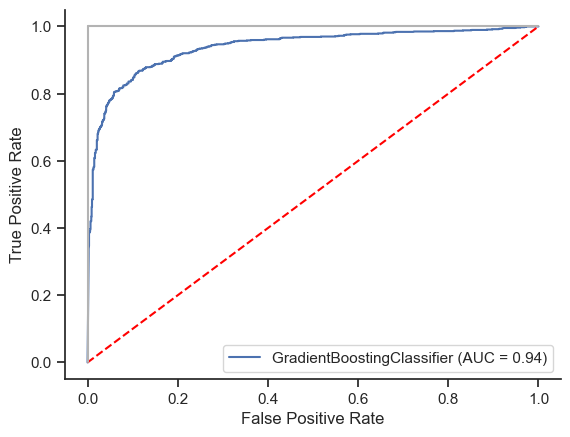

In [38]:
figure(num=None, figsize=(15, 15), dpi=300, facecolor='w', edgecolor='k')

ROC_disp = RocCurveDisplay.from_estimator(gbrt, X_test, y_test)

plt.plot([0, 1], ls="--", color='red')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.savefig('ROCcurve.pdf', bbox_inches='tight')

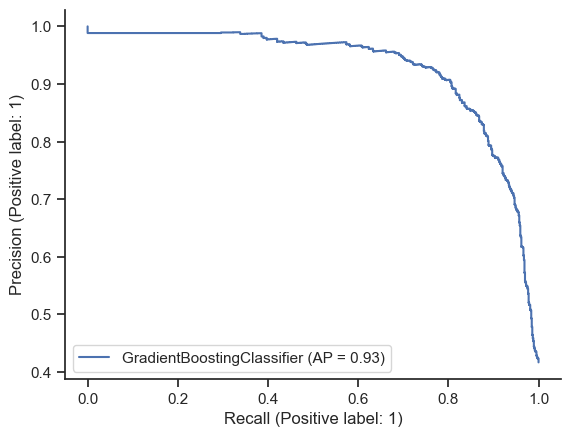

In [39]:
F1_disp = plt.plot()

F1_disp = PrecisionRecallDisplay.from_estimator(gbrt, X_test, y_test, ax=plt.gca())
plt.savefig('F1curve.pdf', bbox_inches='tight')


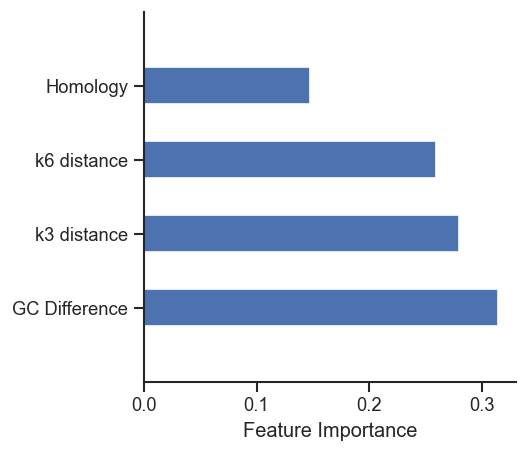

In [40]:
fig = plt.figure(figsize = (4, 4), dpi=120, facecolor='w', edgecolor='k')

features_name = ['GC Difference', 'k3 distance', 'k6 distance', 'Homology']

def plot_feature_importances(model):
    n_features = ml_input.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align = 'center', height=.5)
    plt.yticks(np.arange(n_features), ml_input.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

ax = plt.axes()
#

plot_feature_importances(gbrt)


plt.rc('font', family='Helvetica')

plt.ylabel(None)
plt.yticks(np.arange(4), features_name)

plt.xlabel('Feature Importance')

#plt.savefig('../reports/figures/features_importance_VIPmanuscript.png', bbox_inches='tight')
plt.savefig('features_importance.pdf', bbox_inches='tight')

Confusion matrix

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


y_pred = gbrt.predict(X_test)
print(matthews_corrcoef(y_test, y_pred))

cf_matrix = confusion_matrix(y_pred, y_test)


0.7611885617352304


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


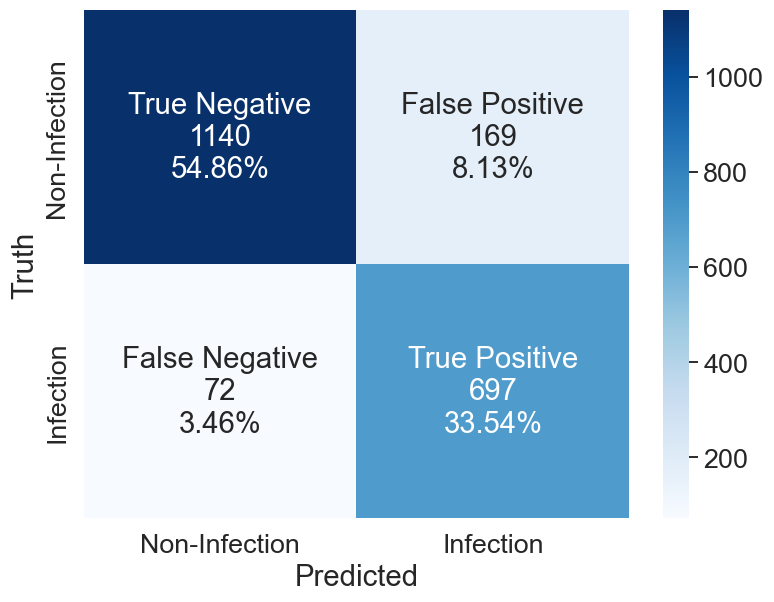

In [43]:
from matplotlib.pyplot import xlabel
from matplotlib.colors import ListedColormap
import seaborn as sns

figure(num=None, figsize=(8, 6), dpi=110, facecolor='w', edgecolor='k')

sns.set(font_scale=1.6)

group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ['{0:.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

legend = ax.legend()

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel = 'Predicted', ylabel = 'Truth', xticklabels=('Non-Infection', 'Infection'), yticklabels=('Non-Infection', 'Infection'))
fig = ax.get_figure()

#fig.savefig('../reports/figures/MLModel_confusionnmatrix_VIPmanuscript.png')
plt.savefig('confusion_matrix.pdf', bbox_inches='tight')

## Save model

In [11]:
# Save model as pickle file
joblib.dump(gbrt, 'gbrt.pkl')

['gbrt.pkl']